一、Django Messages
=====================
以往我們要傳個簡單的提示訊息給使用者要寫 context 並傳給 template render

而 Django Messages 這是一個方便傳訊息的功能，不需要特別寫 context

如下，可以在任何想要的地方加 message，而這些 message 最後會傳給使用者看到

https://docs.djangoproject.com/en/2.2/ref/contrib/messages/

In [ ]:
# blog/views.py
class ArticleCreateView(generic.CreateView):
    template_name = 'blog/article-add.html'
    success_url = reverse_lazy('article-add')
    form_class =  ArticleForm

    def form_valid(self, form):
        article = form.save(commit=False) 
        article.author = self.request.user 
        article.save()
        messages.success(self.request, '成功新增了文章') # message
        return super().form_valid(form)

    def form_invalid(self, form):
        messages.error(self.request, '表單填寫錯誤') # message
        return super().form_invalid(form)

class ArticleUpdateView(generic.UpdateView):
    model = Article
    template_name = 'blog/article-update.html'
    form_class = ArticleForm

    def form_valid(self, form): # 表單成功
        messages.success(self.request, '成功更新了文章') # message
        return super().form_valid(form)

    def form_invalid(self, form): # 表單失敗
        messages.error(self.request, '表單填寫錯誤') # message
        return super().form_invalid(form)

    def get_success_url(self):   
        return reverse_lazy('article-detail', kwargs={'pk': self.object.id,})

class ArticleDeleteView(generic.DeleteView):
    model = Article
    success_url = reverse_lazy('article-list')
    template_name = 'blog/article-delete.html'

    def delete(self, request, *args, **kwargs): # 確認刪除
        messages.success(self.request, '成功刪除了文章') # message
        return super().delete(request, *args, **kwargs)
    
# settings.py

from django.contrib.messages import constants as messages

# 而我為了讓 message render 像 boostrap 的 tag 模式，因此在 settings.py 加這段
MESSAGE_TAGS = {
    messages.ERROR: 'danger' # messages.ERROR 的 tag 預設是 error，這邊改成 danger
}


在 nav_accounts.html 下加一段程式碼，這段是用來 render message 的

In [ ]:
{% if messages %}
  <div class="container">
    {% for message in messages %}
    <div class="alert alert-{{ message.tags }}" role="alert">
      {{ message }}
    </div>
    {% endfor %}
  </div>
{% endif %}

二、Django Admin
=======================
這是 Django 內建的網站後台，專門給 superuser 與 staff 管理 DB 用的

In [ ]:
# blog/admin.py
from blog.models import Article

admin.site.register(Article) # 註冊 Article 可以在 admin 做操作

重啟 server ，進去 http://127.0.0.1:8000/admin/ 可以看到有 Article 的選項

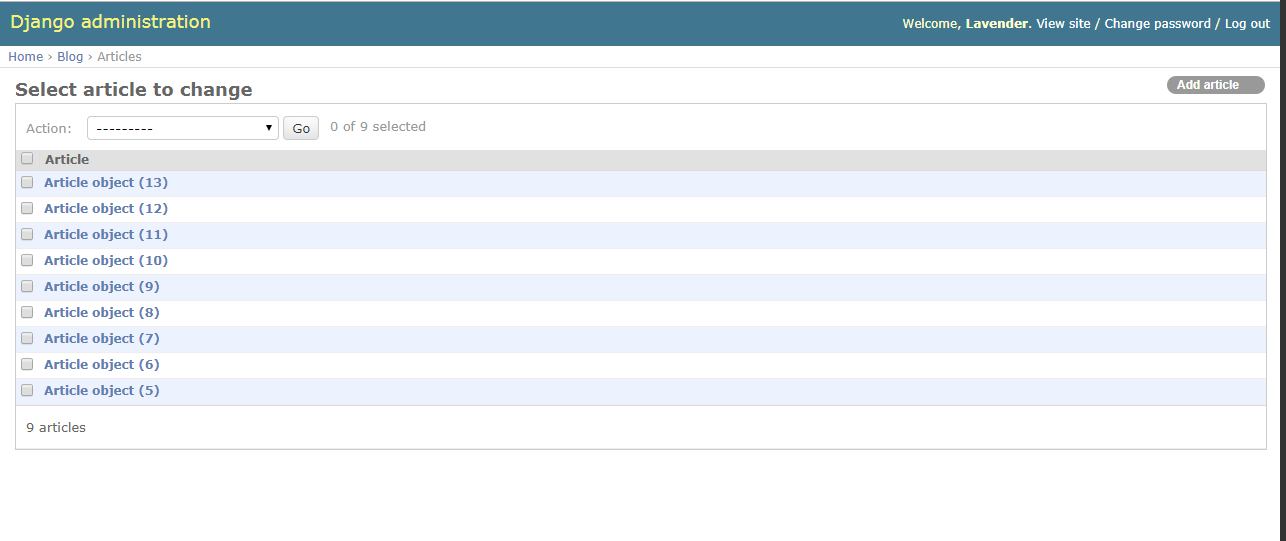

In [1]:
from IPython.display import Image
Image("images/P27.png")

但現在看起來醜醜的，我們可以來設定一些東西讓這個 list 頁看起來更好

In [ ]:
# blog/admin.py
# 修改
class ArticleAdmin(admin.ModelAdmin):
    list_display = ['id', 'author', 'createTime',] # 顯示欄位

admin.site.register(Article, ArticleAdmin)

這邊只是大致上提一下，而這個 Admin 所包的方便的功能就足以應付客戶所提出的後台功能要求。當然也能自己寫自己想要的額外功能(如: 寄信、顯示統計分析...)，而這部份就必須好好研究 admin 的特殊 view 的寫法(其實都是改寫 admin.ModelAdmin 的 function 即可)

詳細操作能看官方文件:
https://docs.djangoproject.com/en/2.2/ref/contrib/admin/

三、Login Required
======================
這在做一個網站當中，我們常設定一個 view 在沒有登入的情況下是不能瀏覽的。其實這個功能不需要額外在 view 寫程式碼判斷 user 是否登入，只要用 Django 的功能來使用即可。

比方說，以登出狀態 http://127.0.0.1:8000/articles/add/ ，其實網頁還是會出來，但試著提交表單就會發現錯誤(因為沒有登入)

In [ ]:
# blog/views.py
from django.contrib.auth.decorators import login_required
from django.utils.decorators import method_decorator

# function view
@login_required
def createArticle(request):
    # ...
  
# class base view
@method_decorator(login_required, name='dispatch')
class ArticleCreateView(generic.FormView):
    # ...
    
# settings.py
LOGIN_URL = '/login/' # 設定登入頁面的網址

會發現當連到 http://127.0.0.1:8000/articles/add/ 會被導到 http://127.0.0.1:8000/login/?next=/articles/add/

next 參數是紀錄使用者是從哪個網頁被 login required 導到 login 頁的，理論上，使用者登入後要幫忙導到原來的頁面，因此我們要在 login view 上下手

In [ ]:
# blog/views.py
class LoginView(generic.View):

    def get(self, request, *args, **kwargs):
        return render(request, 'blog/login.html')

    def post(self, request, *args, **kwargs):
        # 當使用者 POST 表單後運行這部分程式碼
        username = request.POST.get('username')
        password = request.POST.get('password')

        # 用 auth.authenticate 來找 db 內是否有這筆帳戶資料
        user = auth.authenticate(username=username, password=password)
        
        if user and user.is_active: # 判斷 user 是否存在，且沒有被凍結
            # 允許登入
            auth.login(request, user)

            if request.GET.get('next'):
                # 當有 next 參數時，幫忙導頁
                return redirect(request.GET.get('next'))
            return redirect(reverse_lazy('index')) # 進行導頁到 index
        else:     
            # 不允許登入
            context = {
                "msg": "登入失敗",
            }
            return render(request, 'blog/login.html', context)
        
# 此外，blog/login.html 修改
action="{{ request.get_full_path }}" # 這是讓表單也能 Post 記錄在網址上的參數

登出後，再試試  http://127.0.0.1:8000/articles/add/ ，並登入看看是否導到新增文章頁